**Instituto Tecnológico de Aeronáutica – ITA**

**Visão Computacional - CM-203**

**Professores:** 

Elcio Hideiti Shiguemori

Gabriel Adriano de Melo

Marcos Ricardo Omena de Albuquerque Maximo

# Laboratório 1 – Calibração de Câmera


Observação: se estiver usando Colab, para alterar este notebook, salve uma cópia no seu Drive usando ``File > Save a copy in Drive``.

Execute a célula a seguir para instalar as dependências.

In [1]:
!pip3 install opencv-contrib-python==4.6.0.66 Pillow==7.1.2 matplotlib==3.2.2 scipy==1.7.3


[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip


Execute a célula a seguir para importar as bibliotecas necessárias.

In [2]:
import cv2
import numpy as np
from scipy.spatial.transform import Rotation
from PIL import Image
from matplotlib import pyplot as plt
from glob import glob
from pathlib import Path

Execute a célula a seguir para baixar as imagens de calibração da câmera.

In [3]:
import zipfile
import os

# Downloading the zip file
!gdown --id 1vg2fnoLjcYAdF44HxwK41basZUj0xYMN

with zipfile.ZipFile("calib_esq.zip","r") as zip_ref:
    zip_ref.extractall() # Extracts in current directory

# Since we have already unzipped the files, we may now delete the zip file
os.remove("calib_esq.zip")

# Defining the path where the images are located
images_path = 'calib_esq/'

/home/buga/.virtualenvs/cm203/lib/python3.8/site-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1vg2fnoLjcYAdF44HxwK41basZUj0xYMN
To: /home/buga/Desktop/ITA/College/cm203/lab1/calib_esq.zip
100%|██████████████████████████████████████| 42.9M/42.9M [00:09<00:00, 4.58MB/s]


## Introdução sobre Imagens

Vamos carregar uma imagem para explorar como imagens são armazenadas. Vamos carregar uma imagem de calibração com `cv2.imread()` e transformá-las em escala de cinza com `cv2.cvtColor()`.

(1080, 1920)


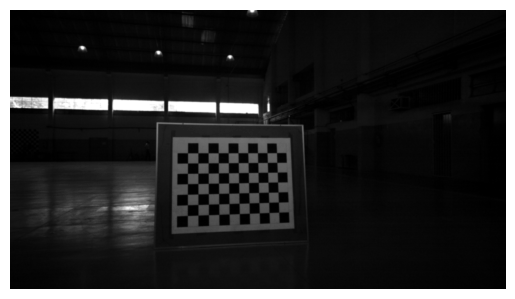

In [5]:
image = cv2.imread(images_path + '00.png', cv2.IMREAD_ANYDEPTH) # Loads the image
plt.imshow(image, cmap='gray', vmin=0, vmax=255) # Shows the image in grayscale
plt.axis(False) # Removes the axes for better visualization
print(image.shape) # Prints the dimensions of the matrix that represents the image

A câmera industrial em questão entrega a imagem no formato bruto (*raw*), sem nenhum processamento. Como ela é colorida, ela tem um padrão de BAYER. No caso específico dela o padrão é Green-Blue (GB), como mostrada na figura abaixo.
![1st Vision GB Pattern](https://www.1stvision.com/machine-vision-solutions/wp-content/uploads/2019/12/RGB-Filter-1.jpg)
Assim, usa-se a função `cv2.cvtColor()` para fazer a interpolação linear para cada canal de cor. O segundo argumento dela é o enum que estabelece o tipo de conversão de cor. Vamos converter do padrão `BAYER_GB` para (2 *to*) `RGB`.

**Observação:** uma grande fonte de confusão é que a OpenCV trabalha `BGR`, porém a convenção `RGB` é muito mais comum. Inclusive, as demais bibliotecas que usamos neste laboratório (Matplotlib e Pillow) usam `RGB`. Cuidado com essa inversão.

(1080, 1920, 3)


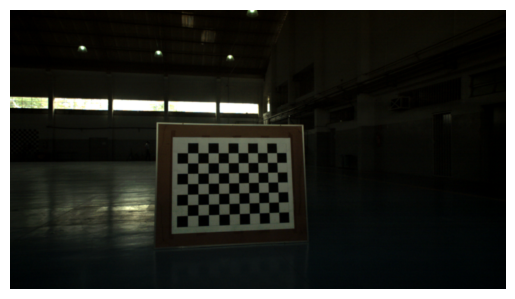

In [6]:
image_color = cv2.cvtColor(image, cv2.COLOR_BAYER_GB2RGB) # Debayering
plt.imshow(image_color)
plt.axis(False)
print(image_color.shape)

Perceba que as imagens são simplesmente matrizes. No caso da imagem bruta, ou em escala de cinza, a dimensão da matriz é simplesmente `(altura, largura)`. Já na imagem colorida, tem-se `(altura, largura, canal_de_cor)`. Há outras bibliotecas que colocam o canal de cor na primeira dimensão (*channels first*), em vez da  (*channels last*), mas o mais comum é colocar os canais de cor na última.

**Observação:** perceba que pela convenção de armazenamento `(linha, coluna)` de uma matriz, os índices acabam ficando trocados para os eixos $x$ e $y$. Tenha muito cuidado para não fazer confusão.

No nosso código, as matrizes são abstraídas por um objeto NumPy `ndarray`. Dessa forma, a sua manipulação e indexação é igual a de uma matriz numérica comum.

Implemente a função ``load_images_and_debayer()``, que carrega todas as imagens .png de uma determinada pasta, realiza o debayering delas através da OpenCV (assumindo formato BAYER GB) e retorna uma lista de imagens coloridas no formato BGR.

In [ ]:
def load_images_and_debayer(path: str):
    """
    Receives a path with .png images in BAYER BG format and returns a list of imagens in BGR format.
    :param path: path where the BAYER BG images are located.
    :return: list with BGR images.
    """
    images = []
    for image_file in sorted(glob(path + '/*.png')):
        # YOUR CODE HERE
        raise NotImplementedError()
    return images

In [ ]:
images = load_images_and_debayer(images_path)
assert len(images) == 35
assert images[0].shape == (1080, 1920, 3)
assert np.all(images[19][19, 19] == [0, 6, 4])
assert np.all(images[19][400, 520] == [18, 33, 47])
assert np.all(images[12][12, 12] == [0, 0, 7])

A célula abaixo exibe todas as imagens de calibração.

In [ ]:
# Loads the images and debayer them
images = load_images_and_debayer(images_path)

num_images = len(images)
columns = 4

# Shows all the calibration images in a grid
plt.figure(figsize=(60, 80))
for i, image in enumerate(images):
    plt.subplot(int(len(images) / columns) + 1, columns, i + 1)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis(False)

## Calibração de Parâmetros Intrísecos e de Distorções

Para as imagens de calibração, é importante ter uma distribuição dos pontos de maneira uniforme ao longo de todo o campo de visão, principalmente pertos dos cantos, onde ocorrem distorções maiores.

Outro ponto importante é variar a inclinação do plano de calibração com relação ao plano da câmera, para que eles não sejam paralelo.

Para a estimação dos parâmetros, quanto maior a quantidade de vértices do tabuleiro, mais estável é a estimação. É claro que um tabuleiro muito grande fica com vértices muito próximos e se estiver longe ou se a resolução for pequena não será possível identificar corretamente os vértices.

No tabuleiro de xadrez das imagens, usou-se 10 e 7 vértices internos em cada dimensão, totalizando 70 vértices. O tabuleiro foi impresso em papel A0 com cada lado medindo 0,1 m.

Depois de termos carregados as imagens, o primeiro passo é fazer de cada vértice/canto (*corner*) interno do tabuleiro. Para isso, usa-se a função `cv2.findChessboardCorners()`, cujo funcionamento interno veremos nas próximas aulas. A ideia é que ela retorna as coordenadas 2D (na imagem) dos vértices internos ordenados. Ela usa operações de *thresholding* e por isso aceita apenas uma imagem com um canal. Outro parâmetro importante é a quantidade de vértices internos do tabuleiro.

In [ ]:
image = cv2.imread(images_path + '05.png', cv2.IMREAD_ANYDEPTH)
num_vertices = (10, 7)
image_grayscale = cv2.cvtColor(image, cv2.COLOR_BAYER_GB2GRAY)
ret, vertices = cv2.findChessboardCorners(image_grayscale, num_vertices)
print(vertices.shape)

Note o formato da matriz de vértices retornado pelo OpenCV. A primeira dimensão se refere ao ponto, a segunda é apenas unitária e a terceira armazena as coordenadas $x$ e $y$ do ponto. Nós podemos visualizar exatamente a ordem e os vértices internos que são retornados, através da função `cv2.drawChessboardCorners()`. Só atentar que ela desenha sobre a imagem original e também com o padrão de cores do OpenCV.

In [ ]:
image_color = cv2.cvtColor(image, cv2.COLOR_BAYER_GB2BGR)
image_corners = cv2.drawChessboardCorners(image_color.copy(), num_vertices, vertices, ret)
Image.fromarray(cv2.cvtColor(image_corners, cv2.COLOR_BGR2RGB))

Perceba que ele começa a percorrer pela primeira dimensão do `num_vertices`, no caso a maior, que está na horizontal. Depois, mude essa parâmetro para (7, 10) e veja a diferença.

As coordenadas do tabuleiro de xadrez da função do `cv2.findChessboardCorners()` tem um nível de exatidão da ordem de 1 pixel, que é a discretização de localização para uma imagem binária (a binarização da imagem, que significa transformar os valores entre 0 a 255 para apenas 0 ou 255 faz parte do *pipeline*). Mas existem métodos que se aproveitam do gradiente da imagem, isto é, do fato de que a borda de alto contraste passa pelo vértice, para interpolar uma posição a nível de subpixel. Para isso tem-se a função `cv2.cornerSubPix()`, que já parte de uma posição inicial da proposição do vértice para iterativamente refiná-la calculando os gradientes da imagem em torno de uma região.

Escreva uma função que receba uma lista de imagens BGR e retorna apenas uma lista de posições dos vértices internos do tabuleiro de xadrez encontrado em cada imagem, já refinados a nível de subpixel.

Para ajudar, veja (🐒):
* Documentação da função ``cv2.cornerSubPix()``: https://docs.opencv.org/4.x/dd/d1a/group__imgproc__feature.html#ga354e0d7c86d0d9da75de9b9701a9a87e
* Tutorial de calibração de câmera: https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html

In [ ]:
def find_and_refine_chessboard_corners(images_list, num_vertices, win_size, criteria):
    """
    Receives a list of BGR images and returns detected corners of a chessboard calibration pattern
    after subpixel refinement. Uses (-1, -1) for the zero zone.
    :param images_list: list of BGR images.
    :param num_vertices: tuple containing the number of vertices along each dimension of the chessboard.
    :param win_size: refinement window size.
    :param criteria: termination criteria for the corner refinement.
    :return: list containing the corners found for each image. Each element of this list is a array
             containing the vertices found in the given image.
    """
    vertices_list = []
    # YOUR CODE HERE
    raise NotImplementedError()
    return vertices_list

In [ ]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 50, 5e-4)
vertices_list = find_and_refine_chessboard_corners(images, num_vertices, (9, 9), criteria)
assert len(vertices_list) < len(images)
assert vertices_list[0].shape == (num_vertices[0] * num_vertices[1], 1, 2)
assert np.linalg.norm(vertices_list[0][0, 0, :] - [1041.6,  785.1]) < 0.3

Agora que já temos as coordenadas 2D de cada posição do tabuleiro, nós temos que saber as coordenadas 3D do tabuleiro, para podermos determinar as matrizes intrínseca e extrínseca, e os parâmetros da distorção.

Se nós soubessemos a posição 3D de cada ponto do tabuleiro com relação à câmera, já poderíamos otimizar direto a matriz intrínseca e os parâmetros de distorção, mas como não sabemos, temos que estimar essa posição do tabuleiro. Mas nós sabemos a posição de um vértice com relação aos outros. Assim podemos definir um sistema de coordenadas do objeto (considerado um corpo rígido), no qual conhecemos exatamente a coordenada de cada vértice, e descobrir apenas a translação e rotação (postura 6D - matriz extrínseca) que leva do sistema de referência do objeto para o sistema de referência da câmera.

Vamos adotar a seguinte convenção para os vértices do tabuleiro (qualquer outra poderia ser adotada, desde que seja consistente): o primeiro vértice do canto superior esquerdo é a origem desse sistema de coordenadas, o eixo X é crescente para a direita e o eixo Y crescente para baixo. O eixo Z é ortogonal ao plano, seguindo a conveção da regra da mão direita.

Assim, implemente uma função que retorne as coordenadas 3D de cada vértice (na mesma ordem definida pela OpenCV, i.e. começando pela primeira dimensão) no sistema de coordenadas do tabuleiro (com a convenção definida anteriormente), em metros.

In [ ]:
def get_board_vertices(num_vertices, square_side):
    """
    Returns a matrix with 3D points of each ordered vertice, in meters.
    :param num_vertices: tuple defining the amount of vertices in each dimension, following OpenCV's convention.
    :param square_side: the length of the side of each square.
    :return: 
    """
    vertices3d = np.zeros((num_vertices[0] * num_vertices[1], 3), dtype=np.float32)
    # YOUR CODE HERE
    raise NotImplementedError()
    return vertices3d

In [ ]:
assert np.all(get_board_vertices((2, 2), 1) == 
                            np.array([[0., 0., 0.],
                                      [1., 0., 0.],
                                      [0., 1., 0.],
                                      [1., 1., 0.]], dtype=np.float32))
vertices3d = get_board_vertices((10, 7), 0.10)

A ideia é que com as coordenadas 3D de cada vértice, descritas no sistema de referência do tabuleiro (corpo rígido), nós possamos encontrar na calibração a mudança de base do tabuleiro para câmera, isto é, a postura.

![Rotação e Translação](https://www.researchgate.net/profile/Rushikesh-Amrutsamanvar/publication/337558917/figure/fig3/AS:830939248734214@1575122763812/Rotation-and-translation-parameters-of-the-camera_W640.jpg)

Assim, basta encontrarmos a rotação e a translação que nos leva do sistema de coordenadas do corpo para o sistema de coordenadas da câmera. Assim nós expressamos a mudança pela seguinte expressão: $X' = R X + T$. É comum também concatenar horizontalmente (`np.hstack`) as matrizes de rotação e translação.

Observe o exemplo abaixo de uma matriz com rotações de 45º no eixo X e depois no eixo Y (ângulos de Euler intrínsecos) e uma translação de 9 metros. Não confunda, primeiro a rotação e depois a translação, fica errado se você alterar a ordem das operações (pois senão a translação seria em outro eixo que não o da câmera).

In [ ]:
rotation_matrix = Rotation.from_euler('XYZ', [45.0, 45.0, 0.0], degrees=True).as_matrix()
translation_vector = np.array([0.0, 0.0, 9.0]).reshape(-1, 1)
(rotation_matrix @ vertices3d.T + translation_vector).T

Finalmente, com a relação de pontos 2D e os seus respectivos pontos 3D, no sistema de coordenadas de um corpo rígido, podemos descobrir o mapeamento entre 2D e 3D, segundo o nosso modelo de geometria projetiva, otimizando os parâmetros da câmera e da postura do objetivo simultaneamente.

Para isso podemos usar a função `cv2.calibrateCameraExtended()`, que faz essa otimização iterativamente. Além dos parâmetros otimizados, nos retorna as incertezas e os erros residuais da otimização. Esses erros vem da reprojeção dos pontos 3D, segundo a postura encontrada e os parâmetros da câmera, e calculando a distância do ponto reprojetada para o ponto 2D determinado.

Implemente `calibrate_camera()` abaixo, usando a função da OpenCV para calibrar. Para descobrir como utilizar `cv2.calibrateCameraExtended()`, verifique a documentação e *tutoriais* da OpenCV. Procurar a documentação desta função pode ser vista aqui: https://docs.opencv.org/4.6.0/d9/d0c/group__calib3d.html

Atenção que o parâmetro `objectPoints` da função é uma lista de `coords3d` cujo cada elemento está associado ao seu respectivo par 2D, que é uma lista onde cada elemento representa um tabuleiro (`imagePoints`). No caso, como todas as fotos são do mesmo tabuleiro do mesmo tamanho, é só criar uma lista com $N$ elementos repetidos de `verts3d`.

Atente que o `imageSize` é o tamanho da imagem em largura por altura (que é o contrário do shape de linhas por colunas).

Os parâmetros de `cameraMatrix` e `distCoeffs` podem ser passados como `None`, na realidade eles são um resquício do código em C que são passados por referência.

As distorções da lentes são um mapeamento 2D-2D, biunívoco, contínuo e suave. No modelo mais simples de 5 parâmetros, tem uma componente radial (a partir do centro óptico $c_x$ e $c_y$) e outra cruzada (tangencial).
![Distorções 2d](https://docs.opencv.org/4.x/distortion_examples.png)

In [ ]:
def calibrate_camera(coords2d_list, coords3d, image_size, flags=None):
    """
    Calibrates a camera using cv2.calibrateCameraExtended().
    :param coords2d_list: list of 2D coordinates of the board's vertices.
    :param coords3d: 3D coordinates of the board's vertices.
    :param image_size: the image size in terms of width and height.
    Returns the return values of cv2.calibrateCameraExtended(). Please, see OpenCV documentation.
    """
    # Hint: coords3d represents the same object (the board) for all images. However, OpenCV expects
    # a list of coords3d as objectPoints. Therefore, you need to replicate coords3d using the number
    # of images.
    # YOUR CODE HERE
    raise NotImplementedError()
    return error, camera_matrix, dist_coeffs, rvecs, tvecs, std_intrinsics, std_extrinsics, per_view_errors

In [ ]:
error, camera_matrix, dist_coeffs, rvecs, tvecs, std_intrinsics, std_extrinsics, per_view_errors =\
calibrate_camera(vertices_list[:-6], vertices3d, image_grayscale.shape[::-1], flags=None)
assert error < 1
assert np.linalg.norm(camera_matrix -
np.array([[1.27609629e+03, 0.00000000e+00, 9.48102766e+02],
          [0.00000000e+00, 1.28017819e+03, 5.27661311e+02],
          [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])) < 10
assert np.linalg.norm(dist_coeffs) < 0.2

In [ ]:
error, camera_matrix, dist_coeffs, rvecs, tvecs, std_intrinsics, std_extrinsics, per_view_errors =\
calibrate_camera(vertices_list[:], vertices3d, image_grayscale.shape[::-1], flags=cv2.CALIB_FIX_ASPECT_RATIO)
print('error: %f' % error)
print('per_view_errors:')
print(per_view_errors)
print('camera_matrix:')
print(camera_matrix)
print('dist_coeffs:')
print(dist_coeffs)
print('std_intrinsics:')
print(std_intrinsics)

Veja os resultados e reflita se fazem sentido:
o `error` e o `per_view_errors` são erros de reprojeção em pixels;
Temos a matrix intríseca `camera_matrix`, coeficiente de distorção `dist_coeffs`, e o desvio padrão estimado para esses parâmetros `std_intrinsics`.

A rotação calculada pelo OpenCV `rvecs` está no formato de uma lista de Vetor de Rodrigues, em radianos. O Vetor de Rodrigues é simplesmente um vetor de rotação cuja direção define o eixo de rotação e cuja magnitude define o ângulo rotacionado em torno daquele eixo, com sentido dado pela regra da mão direita.

![Vetor de Rodrigues](https://upload.wikimedia.org/wikipedia/commons/7/7b/Angle_axis_vector.svg)

Por exemplo, um vetor de rodrigues `(0, 0, pi/4)` define uma rotação de 45º em torno do eixo Z, que resulta na matriz de rotação abaixo:

In [ ]:
Rotation.from_rotvec([0, 0, np.pi / 4]).as_matrix()

A distorção é bem pequena para esse conjunto de lentes, sendo da ordem de alguns pixels nas bordas. Observe a região preta das boradas da imagem abaixo, depois que a distorção foi removida. Foi adicionado um valor constante (*offset*) nos *pixels* da imagem original para facilitar a visualização desta borda (o *cast* para `uint16` foi feito para evitar *overflow*).

In [ ]:
new_camera_matrix, roi =\
cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coeffs, image_grayscale.shape[::-1], 1)
offset = 60
image_with_offset = np.clip(image.astype(np.uint16) + offset, 0, 255).astype(np.uint8)
undistorted_image = cv2.undistort(image_with_offset, camera_matrix, dist_coeffs, None, new_camera_matrix)
print(undistorted_image.shape)
Image.fromarray(undistorted_image)

Vamos verificar a reprojeção dos pontos do tabuleiro em uma imagem, isto é, sabendo as posições 3D dos pontos no sistema de referência do tabuleiro `vertices3d`, e sabendo a pose do tabuleiro `rvecs[1]` e `tvecs[1]`, além do íntrínseco da câmera `camera_matrix` e `dist_coeffs`, fazemos esta projeção do 3D do mundo para o 2D da câmera.

In [ ]:
projected_points, jacobian = cv2.projectPoints(vertices3d, rvecs[1], tvecs[1], camera_matrix, dist_coeffs)
image = cv2.cvtColor(cv2.imread(images_path + '/01.png', cv2.IMREAD_ANYDEPTH), cv2.COLOR_BAYER_GB2RGB)
for p in projected_points:
    cv2.circle(image, p.ravel().astype(np.int32), 6, (0, 255, 0), 2)
Image.fromarray(image)

Na realidade, com o nosso tabuleiro em posição conhecida, podemos projetar os pontos que quisermos, veja por exemplo o eixo do sistema de referência do tabuleiro, o eixo X é o vermelho, o eixo verde é o Y, e o azul é o eixo Z. (Se não prestar atenção no BRG e RGB fica trocado o azul e o vermelho).

Perceba que pela simetria, o sistema de coordenadas pode estar rotacionado de 180º.

In [ ]:
image = cv2.cvtColor(cv2.imread(images_path + '/01.png', cv2.IMREAD_ANYDEPTH), cv2.COLOR_BAYER_GB2BGR)
cv2.drawFrameAxes(image, camera_matrix, dist_coeffs, rvecs[1], tvecs[1], 0.5)
Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

E agora se estivéssemos em uma aplicação de AR (Augmented Reality), poderíamos projetar uma geometria arbitrária sobre o tabuleiro de xadrez. Vamos desenha um novo tabuleiro virtual verde afastado 0.15 m do original, isso apenas calculando a projeção dos pontos deslocados.

In [ ]:
image = cv2.cvtColor(cv2.imread(images_path + '/01.png', cv2.IMREAD_ANYDEPTH), cv2.COLOR_BAYER_GB2BGR)
reprojected_points1, _ = cv2.projectPoints(vertices3d, rvecs[1], tvecs[1], camera_matrix, dist_coeffs)
reprojected_points2, _ = cv2.projectPoints(vertices3d + np.array([[0, 0, -0.15]]), rvecs[1], tvecs[1], camera_matrix, dist_coeffs)
for p1, p2 in zip(reprojected_points1, reprojected_points2):
    cv2.line(image, p1.ravel().astype(np.int32), p2.ravel().astype(np.int32), (0, 255, 0), 2)
for i, p in enumerate(reprojected_points2):
    if i % num_vertices[0] != num_vertices[0] - 1:
        cv2.line(image, p.ravel().astype(np.int32), reprojected_points2[i + 1].ravel().astype(np.int32), (50, 200, 100), 2)
    if i < (num_vertices[1] - 1) * num_vertices[0]:
        cv2.line(image, p.ravel().astype(np.int32), reprojected_points2[i + num_vertices[0]].ravel().astype(np.int32), (50, 200, 100), 2)
Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

Agora que já realizamos a calibração e fizemos alguns experimentos, vamos implementar o nosso próprio `projectPoints` com o que já aprendemos

Assim, primeiro você deverá fazer a transformação de coordenadas (do referencial do objeto para o da câmera), em seguida aplique a transformação projetiva para obter pontos 2D e finalmente aplique o modelo de distorção, mapeando os pontos 2D em outros pontos 2D.

A OpenCV usa o seguinte modelo de distorção:

\begin{equation}
\begin{bmatrix} x \\ y \\ z \end{bmatrix} = 
\mathbf{R}
\begin{bmatrix} x_g \\ y_g \\ z_g \end{bmatrix} + \mathbf{t},
\end{equation}

\begin{equation}
x' = x/z, \\
y' = y/z,
\end{equation}

\begin{equation}
x'' = x' \dfrac{1+k_1 r^2 + k_2 r^4 +k_3 r^6}{1 + k_4 r^2 + k_5 r^4 + k_6 r^6} + 2 p_1 x' y' + p_2 (r^2 + 2x'^2), \\
y'' = y' \dfrac{1+k_1 r^2 + k_2 r^4 +k_3 r^6}{1 + k_4 r^2 + k_5 r^4 + k_6 r^6} + p_1 (r^2 + 2 y'^2) + 2p_2 x' y',
\end{equation}
em que $r=\sqrt{x'^2 + y'^2}$ e $(x'', y'')$ é o valor do ponto distorcido. Assim, após a distorção, a transformação para o espaço da imagem é feita por
\begin{equation}
u = f_x x'' + c_x, \\
v = f_y y'' + c_y.
\end{equation}

O vetor de distorções é definido (pelo OpenCV da seguinte forma):

`dist_coeffs`=$(k_1 \hspace{10pt} k_2 \hspace{10pt} p_1 \hspace{10pt} p_2 \hspace{10pt} k_3)$

Neste caso, considera-se que $k_4=k_5=k_6=0$.

In [ ]:
def project_points(object_points, rvec, tvec, camera_matrix, dist_coeffs):
    """
    Your implementation of OpenCV's projectPoints() method.
    :param object_points: 3D points in format (N, 3) where N is the number of points.
    :param rvec: Rotation vector (Rodrigues convention), part of the extrinsic parameters.
    :param tvec: translation vector, part of the extrinsic parameters.
    :param camera_matrix: intrisic matrix.
    :param dist_coeffs: distortion coefficients following (k1, k2, p1, p2, k3).
    :return: projected 2D image points.
    """
    fx = camera_matrix[0, 0]
    fy = camera_matrix[1, 1]
    cx = camera_matrix[0, 2]
    cy = camera_matrix[1, 2]
    k1, k2, p1, p2, k3 = dist_coeffs.ravel()
    rotation_matrix, _ = cv2.Rodrigues(rvec)
    # YOUR CODE HERE
    raise NotImplementedError()
    return image_points

In [ ]:
points3d_test = np.arange(30, dtype=np.float32).reshape(-1, 3)
mtx_test = np.array([[1000, 0, 1000], [0, 1000, 1000], [0, 0, 1]], dtype=np.float32)
rot_test = Rotation.from_euler('XYZ', [45, 30, 60], degrees=True)
tvec_test = np.array([3, 4, 10], dtype=np.float32).reshape(-1, 1)
myproj_test = project_points(points3d_test, rot_test.as_rotvec(), tvec_test, mtx_test,  np.zeros(5))
cvproj_test, _ = cv2.projectPoints(points3d_test, rot_test.as_rotvec(), tvec_test, mtx_test,  np.zeros(5))
assert np.linalg.norm(myproj_test - cvproj_test.reshape(-1, 2)) < 1e-2

As células a seguir repetem as projeções já realizadas anteriormente no tabuleiro, mas utilizando a função ``my_project_points()`` ao invés da função ``cv2.projectPoints()``.

In [ ]:
projected_points = project_points(vertices3d, rvecs[1], tvecs[1], camera_matrix, dist_coeffs)
image = cv2.cvtColor(cv2.imread(images_path + '/01.png', cv2.IMREAD_ANYDEPTH), cv2.COLOR_BAYER_GB2RGB)
for p in projected_points:
    cv2.circle(image, p.ravel().astype(np.int32), 6, (0, 255, 0), 2)
Image.fromarray(image)

In [ ]:
image = cv2.cvtColor(cv2.imread(images_path + '/01.png', cv2.IMREAD_ANYDEPTH), cv2.COLOR_BAYER_GB2BGR)
reprojected_points1 = project_points(vertices3d, rvecs[1], tvecs[1], camera_matrix, dist_coeffs)
reprojected_points2 = project_points(vertices3d + np.array([[0, 0, -0.15]]), rvecs[1], tvecs[1], camera_matrix, dist_coeffs)
for p1, p2 in zip(reprojected_points1, reprojected_points2):
    cv2.line(image, p1.ravel().astype(np.int32), p2.ravel().astype(np.int32), (0, 255, 0), 2)
for i, p in enumerate(reprojected_points2):
    if i % num_vertices[0] != num_vertices[0] - 1:
        cv2.line(image, p.ravel().astype(np.int32), reprojected_points2[i + 1].ravel().astype(np.int32), (50, 200, 100), 2)
    if i < (num_vertices[1] - 1) * num_vertices[0]:
        cv2.line(image, p.ravel().astype(np.int32), reprojected_points2[i + num_vertices[0]].ravel().astype(np.int32), (50, 200, 100), 2)
Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))